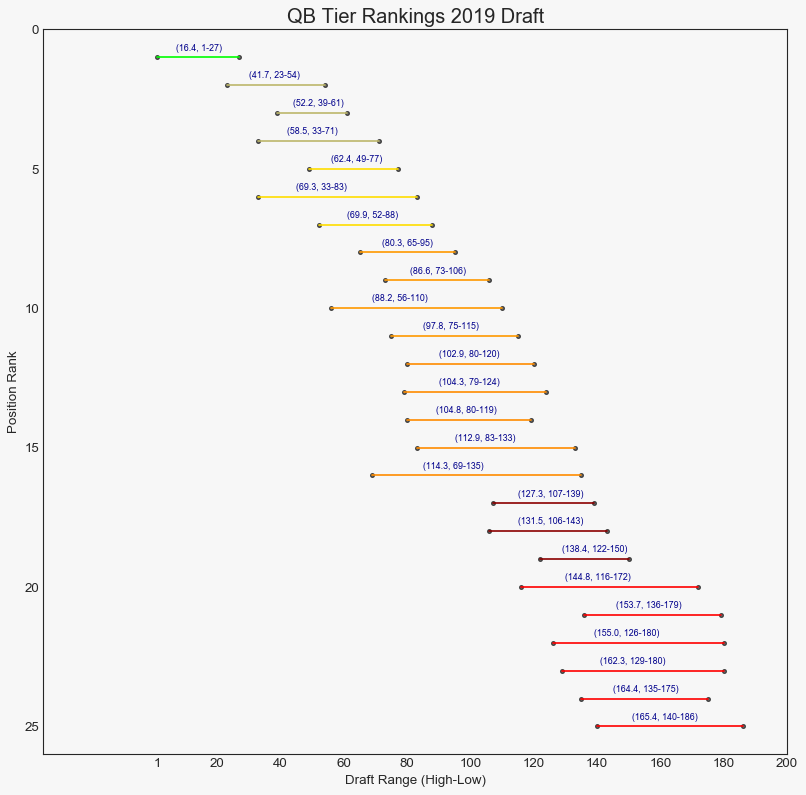

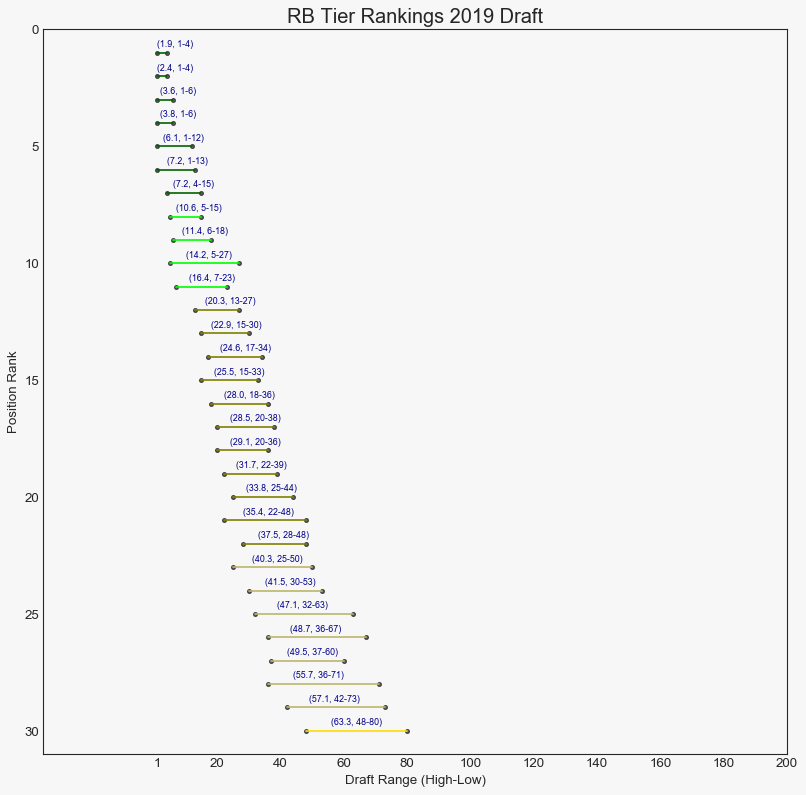

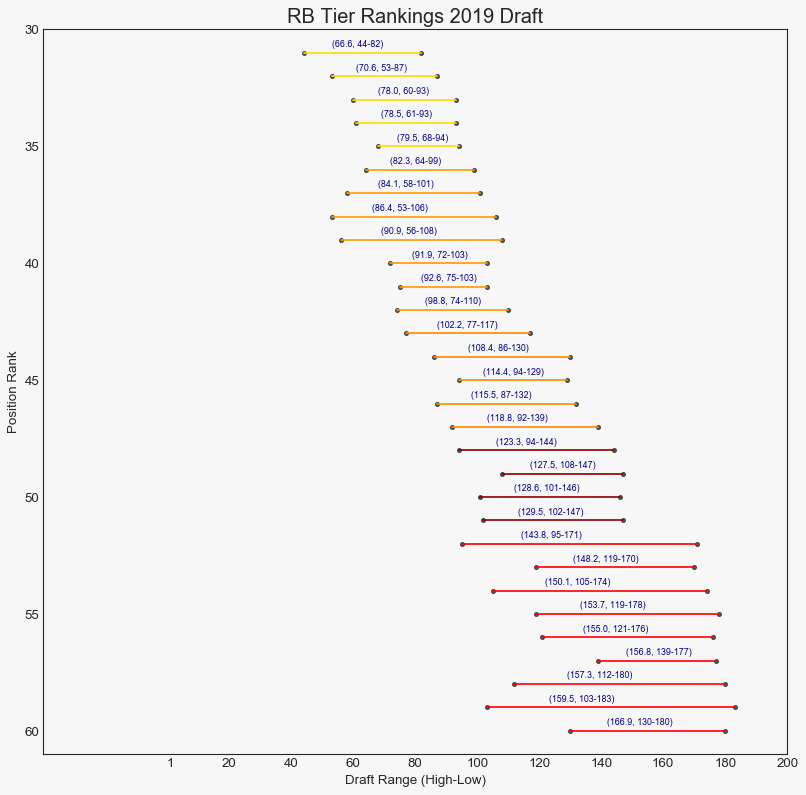

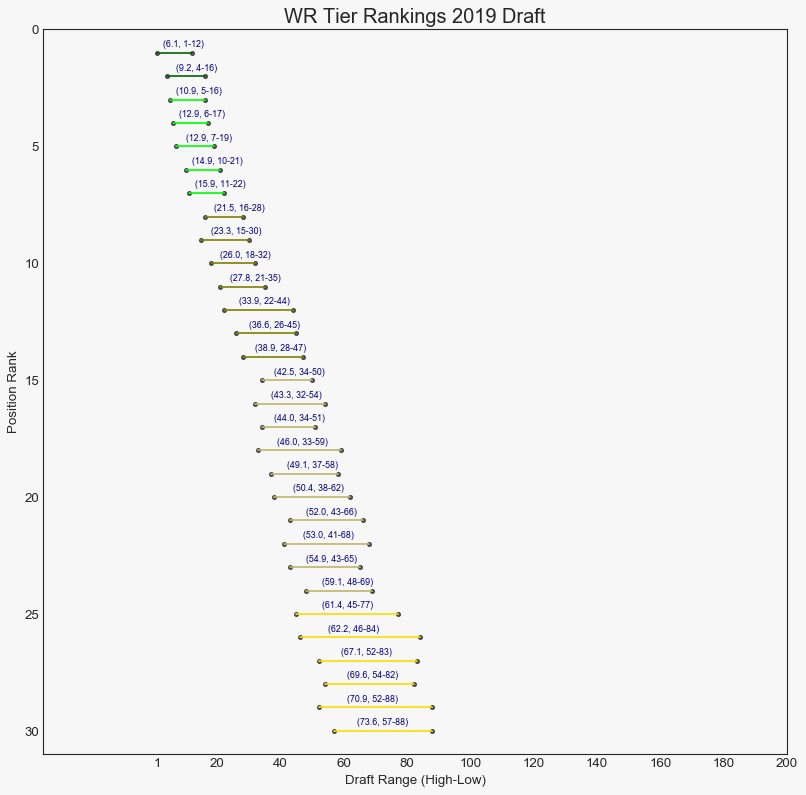

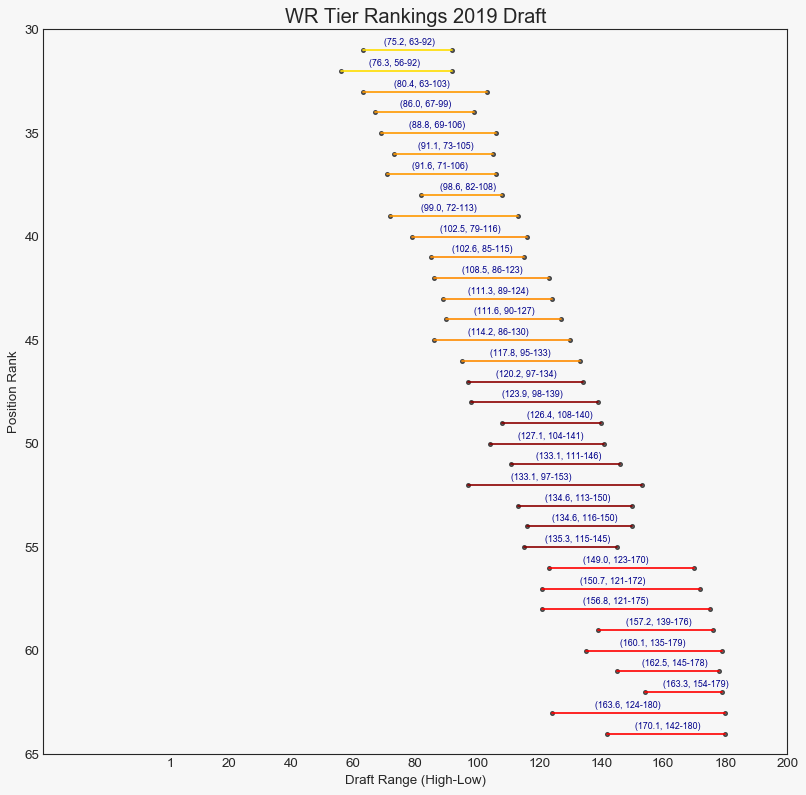

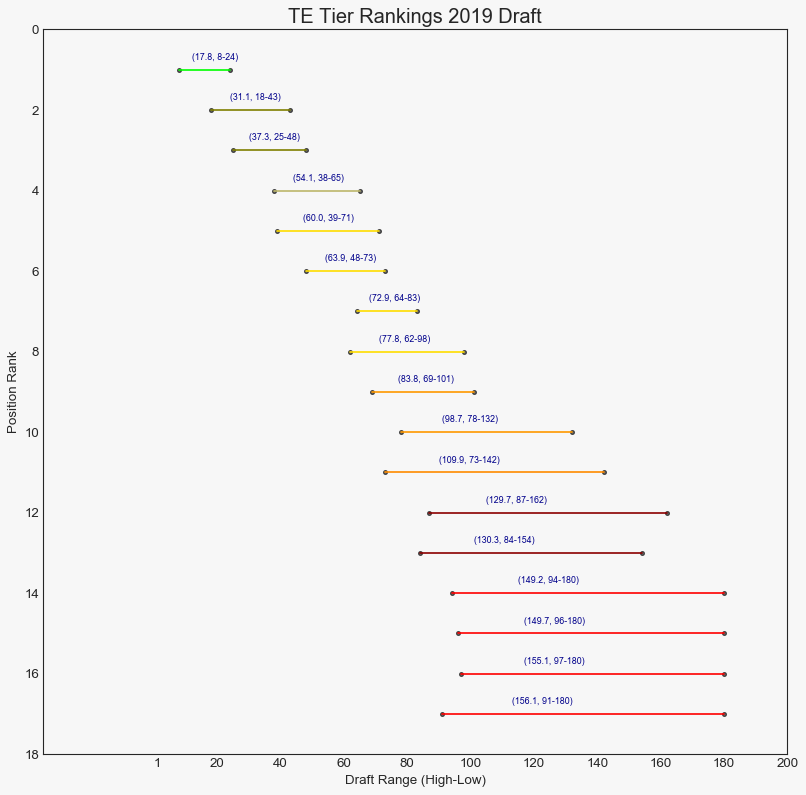

In [3]:
import requests
import warnings; warnings.filterwarnings(action='once')
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns


large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': small,
          'axes.titlesize': med,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")


#======== Functions ==============================

#Creates dataframe from API data based on league size and year
def fc_adp(scoring='standards', teams=10, year=2018):
    ffc_com = 'https://fantasyfootballcalculator.com'
    resp = requests.get(f'{ffc_com}/api/v1/adp/{scoring}?teams={teams}&year={year}')
    if resp.status_code != 200:
        print('Failed to get data:', resp.status_code)
    else:
        df = pd.DataFrame(resp.json()['players'])
        df['year'] = year
        df['teams'] = teams
    return df

#Creates dataframe based on position
def df_position(df, position):
    df['all'] = "("+ df['adp'].map(str) + ", " + df['high'].map(str) + "-" + df['low'].map(str) + ")"
    position_df = df[df['position']==position]
    pos_df = position_df[['name','adp','high','low','all']].copy()    
    pos_df.index = range(1, len(pos_df.index)+1)
    return pos_df


# Repositions names and draft data to be easy to read
def gname_position(name):
    if (len(name) == 11):
        difference = -25
    elif (len(name) < 11):
        add = 11 - len(name)
        difference = add - 27
    else:
        subtract = len(name) - 11
        difference = -27 - subtract
    return difference

def gdata_position(low, high):
    position = (high - low) // 4
    return position 
    

# Func to draw line segment
def newline_tier(name, adp, p1, p2, data):
    ax = plt.gca()
    
    #Slices each ADP to the closest round
    if(adp < 10):
        adp = str(adp)
        adp_slice = 1
    elif (10 < adp < 100):
        adp = str(adp)
        adp_slice = int(adp[0]) + 1
    else:
        adp = str(adp)
        adp_slice = int(adp[0:2]) + 1
        
    #diff = gname_position(name)
    data_pos = gdata_position(p1[0], p2[0])
    
    #Tier Rankings by Color
    if  (adp_slice == 1):
        l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='darkgreen')
        plt.text(p1[0]+diff, p2[1], name, fontsize=10, fontweight='bold', color='darkgreen')
        plt.text(p1[0]+data_pos, p2[1]-0.25, data, fontsize=8, color='darkblue')
    elif (adp_slice == 2):
        l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='lime')
        plt.text(p1[0]+diff, p2[1], name, fontsize=10, fontweight='bold', color='lime')
        plt.text(p1[0]+data_pos, p2[1]-0.25, data, fontsize=8, color='darkblue')
    elif (3 <= adp_slice <= 4):
        l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='olive')
        plt.text(p1[0]+diff, p2[1], name, fontsize=10, fontweight='bold', color='olive')
        plt.text(p1[0]+data_pos, p2[1]-0.25, data, fontsize=8, color='darkblue')
    elif (5 <= adp_slice <= 6):
        l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='darkkhaki')
        plt.text(p1[0]+diff, p2[1], name, fontsize=10, fontweight='bold', color='darkkhaki')
        plt.text(p1[0]+data_pos, p2[1]-0.25, data, fontsize=8, color='darkblue')
    elif (7 <= adp_slice <= 8):
        l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='#FFDD00')
        plt.text(p1[0]+diff, p2[1], name, fontsize=10, fontweight='bold', color='#FFDD00')
        plt.text(p1[0]+data_pos, p2[1]-0.25, data, fontsize=8, color='darkblue')
    elif (9 <= adp_slice <= 10):
        l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='#FF9900')
        plt.text(p1[0]+diff, p2[1], name, fontsize=10, fontweight='bold', color='#FF9900')
        plt.text(p1[0]+data_pos, p2[1]-0.25, data, fontsize=8, color='darkblue')
    elif (11 <= adp_slice <= 12):
        l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='darkorange')
        plt.text(p1[0]+diff, p2[1], name, fontsize=10, fontweight='bold', color='darkorange')
        plt.text(p1[0]+data_pos, p2[1]-0.25, data, fontsize=8, color='darkblue')
    elif (13 <= adp_slice <= 14):
        l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='darkred')
        plt.text(p1[0]+diff, p2[1], name, fontsize=10, fontweight='bold', color='darkred')
        plt.text(p1[0]+data_pos, p2[1]-0.25, data, fontsize=8, color='darkblue')
    else:
        l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='red')
        plt.text(p1[0]+diff, p2[1], name, fontsize=10, fontweight='bold', color='red')
        plt.text(p1[0]+data_pos, p2[1]-0.25, data, fontsize=8, color='darkblue')
   
    ax.add_line(l)
    return l

def graph(df, position):
    row_count = len(df.index)
    idx_last = df.index.max()
    idx_first = df.index.min()
    last_low = df.loc[idx_last, 'low']
    
    # Figure and Axes
    fig, ax = plt.subplots(1,1,figsize=(12,12), facecolor='#f7f7f7', dpi= 80)

    # Points
    ax.scatter(y=df.index, x=df['high'], s=12.5, color='black', alpha=0.6)
    ax.scatter(y=df.index, x=df['low'], s=12.5, color='black', alpha=0.6)

    # Line Segments
    for name, adp, i, high, low, data in zip(df['name'], df['adp'], df.index, df['high'], df['low'], df['all']):
        newline_tier(name, adp, [high, i], [low, i], data)
    
    # Graph Decorations
    
    # RB and WR 2nd Group Graphs
    if (idx_first > 30):
        ax.set_facecolor('#f7f7f7')
        title = position + " Tier Rankings " + str(year) + " Draft"
            
        ax.set_title(title, fontdict={'size':18})
        ax.set(xlim=(-40, idx_last), xlabel='Draft Range (High-Low)', ylim=(idx_last+1, 30), ylabel='Position Rank')
        ax.set_xticks([1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
        ax.set_xticklabels(['1', '20', '40', '60', '80', '100', '120', '140', '160', '180','200']) 
        plt.gcf()    

    else:
    # All other graphs
        ax.set_facecolor('#f7f7f7')
        title = position + " Tier Rankings " + str(year) + " Draft"
        ax.set_title(title, fontdict={'size':18})
        ax.set(xlim=(-35, idx_last), xlabel='Draft Range (ADP, High-Low)', ylim=(idx_last+1, 0), ylabel='Position Rank')
        ax.set_xticks([1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
        ax.set_xticklabels(['1', '20', '40', '60', '80', '100', '120', '140', '160', '180','200'])  
        plt.gcf()


#============= Main ====================================================

positions = ['QB', 'RB', 'WR', 'TE']
year = 2019
teams = 10

api = fc_adp('standard', teams, year)

for position in positions:
    df = df_position(api, position)
    row_count = len(df.index)
    
    if(row_count > 30):
        df1 = df.iloc[:30,:]
        df2 = df.iloc[30:,:]
        graph(df1, position)
        graph(df2, position)
    else:
        graph(df, position)
